# Dragging gestures: Analysis

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, shutil
import sympy as sp

# before attemping to import these, two, make sure you upload them to the folder
# where this ipynb is located !!!!
import display_properties
import curve_functions

# for linear regression summary
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad
from scipy.stats import shapiro as normal_shapiro

from analysis import Analysis
from analysisargs import AnalysisArgs, Logs
import participants

Screen X Size: 13.596578379142969
Screen Y Size: 7.64807533826792
FIgure DPI 141.21199808219862
Cartesian Unit len (inches) 1.6801605376106268
Cartesian Unit len (cm) 4.267607765530992
Polar Unit len (inches) 1.529615067653584
Polar Unit len (cm) 3.8852222718401035
Linewidth in inches: 0.013888888888888888
Linewidth in centimeters: 0.035277777777777776


In [3]:
args = AnalysisArgs()
args.centralTendency = 'mean'
logs = Logs()
AN = Analysis(args=args, logs=logs)
PA = participants.ParticipantAnalysis(logs=logs)

In [5]:
# prepare folders and erase all figures
# only remove folders which are going to be changed by executing this script

figuresFoldername = 'figures'
drawingTimeHistogramsFoldername = 'drawing_time_histograms'
linearRegressionFoldername = 'linear_regressions'
takeScreenshots = False
useCroatian = True

drawingTimeHistogramsFolderPath = figuresFoldername + "/" + drawingTimeHistogramsFoldername + "/"
linearRegressionsFolderPath = figuresFoldername + "/" + linearRegressionFoldername \
    + "/" + args.iodModelName \
    + "/" + args.centralTendency + "/"
participantDataFolderPath = figuresFoldername + "/participants/"

def saveFigure(figurename):
    figurename = figurename.replace(' ', '_').replace('\n', '')
    if(takeScreenshots is True):
        plt.savefig(figurename)

def resetFigureFolder(foldername):
    if(os.path.exists(foldername)):
        shutil.rmtree(foldername)
    os.makedirs(foldername)

if(takeScreenshots is True):
    foldersToBeChanged = [
        drawingTimeHistogramsFolderPath,
        linearRegressionsFolderPath,
        participantDataFolderPath
    ]
    
    for foldername in foldersToBeChanged:
        print(foldername)
        resetFigureFolder(foldername)    

def translateWord(word):
    retval = ""
    if(word == "Cartesian"):
        retval = "Kartezijev"
    elif(word == "Polar"):
        retval = "Polarni"
    elif word == "Mouse":
        retval = "Miš"
    elif word == "Graphic tablet":
        retval = "Grafički tablet"
    elif word == "median":
        retval = "medijan"
    elif word == "mean":
        retval = "Arit.sred."
    else:
        retval = word + " - neprevedeno"
    return retval
        
def translate(words):
    if(useCroatian is False):
        return words
    
    if(type(words) is not list):
        return translateWord(words)
    
    retval = []
    for word in words:
            retval.append(translateWord(word))
    return retval

# Linear regression



SKLEARN
Linear regression for ['Cartesian'], Mouse, mode=[0],
Central Tendency=mean,Index Of Difficulty=tmp
1.4271019243478793
MT = 1.242x + -4.426
R^2 = 0.999
MSE = 0.291
RMSPE = 1.427%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.39830636978149414
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.39830636978149414
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation


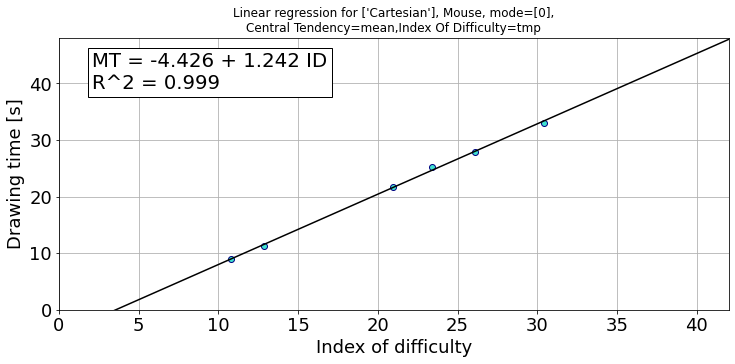

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.11714788526296616
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.11714788526296616
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9823971325625038
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should 

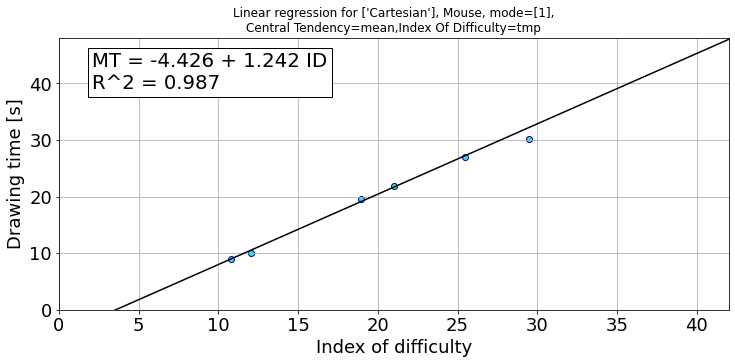



SKLEARN
Linear regression for ['Cartesian'], Graphic tablet, mode=[0],
Central Tendency=mean,Index Of Difficulty=tmp
2.595844385790779
MT = 1.167x + -2.886
R^2 = 0.993
MSE = 0.696
RMSPE = 2.596%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.8444543480873108
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.8444543480873108
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrel

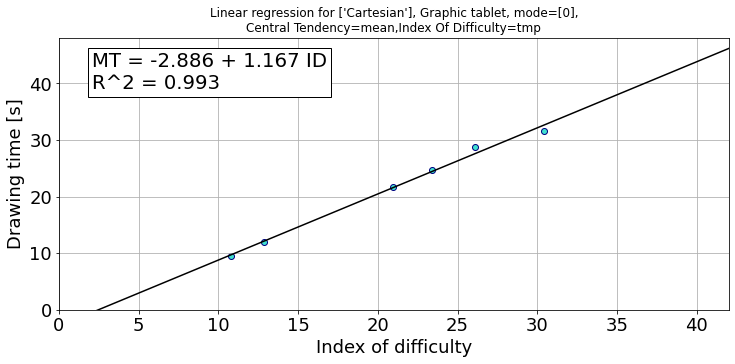

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5608201026916504
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.5608201026916504
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.22780835300142094
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals

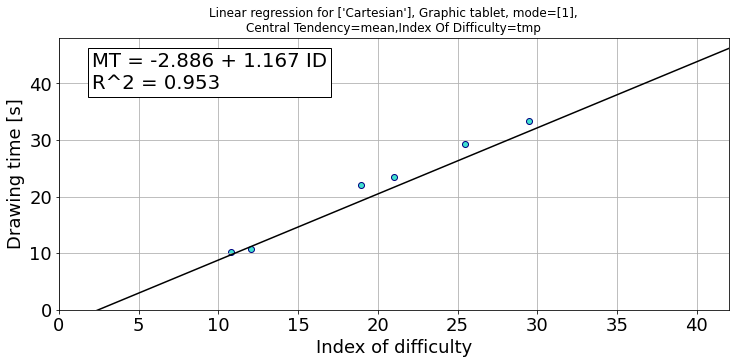



SKLEARN
Linear regression for ['Polar'], Mouse, mode=[0],
Central Tendency=mean,Index Of Difficulty=tmp
2.557783475442931
MT = 1.283x + -5.834
R^2 = 0.995
MSE = 0.547
RMSPE = 2.558%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.7240586876869202
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.7240586876869202
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------

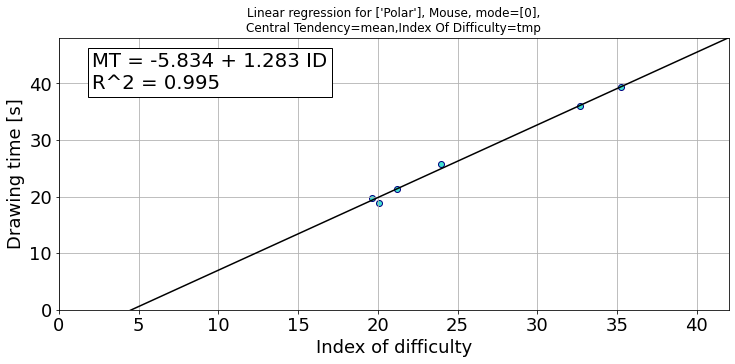

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.2849704325199127
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.2849704325199127
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.476269089472921
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals s

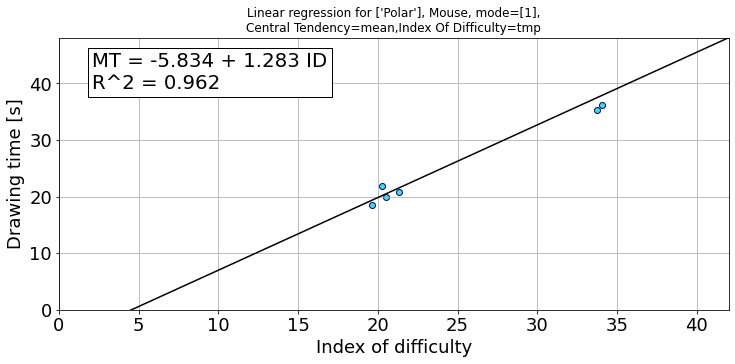



SKLEARN
Linear regression for ['Polar'], Graphic tablet, mode=[0],
Central Tendency=mean,Index Of Difficulty=tmp
3.7906528667275965
MT = 1.204x + -3.474
R^2 = 0.988
MSE = 0.832
RMSPE = 3.791%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5194879770278931
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.5194879770278931
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelati

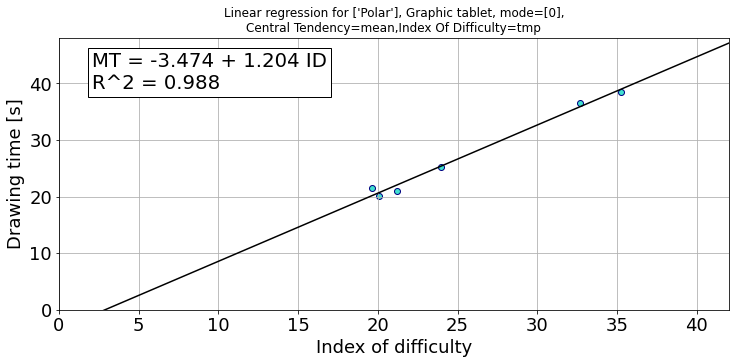

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.15485964715480804
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.15485964715480804
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.2795396674804001
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residual

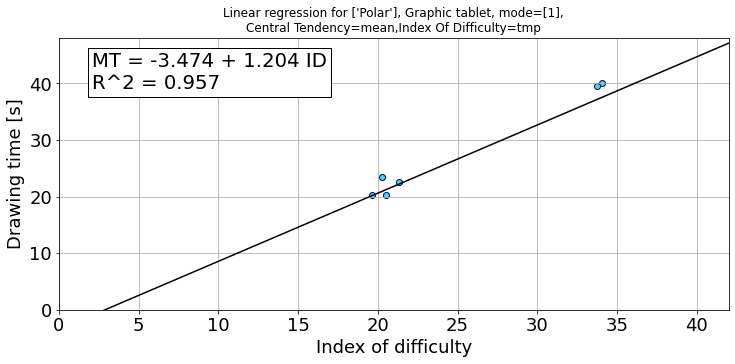



SKLEARN
Linear regression for ['Cartesian', 'Polar'], Mouse, mode=[0],
Central Tendency=mean,Index Of Difficulty=tmp
2.517232500206289
MT = 1.249x + -4.776
R^2 = 0.997
MSE = 0.506
RMSPE = 2.517%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.11011545360088348
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.11011545360088348
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorr

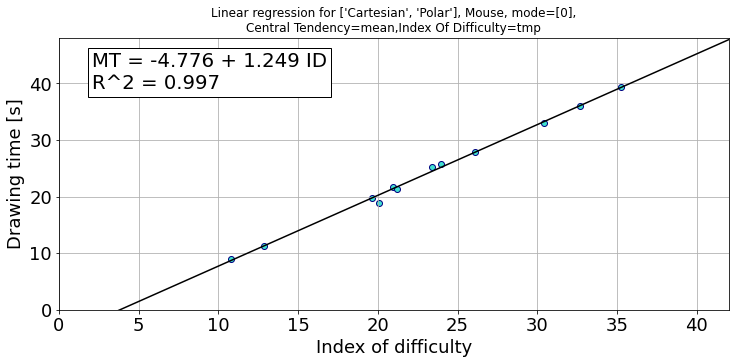

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.7204043865203857
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.7204043865203857
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.5174303684046213
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should ha

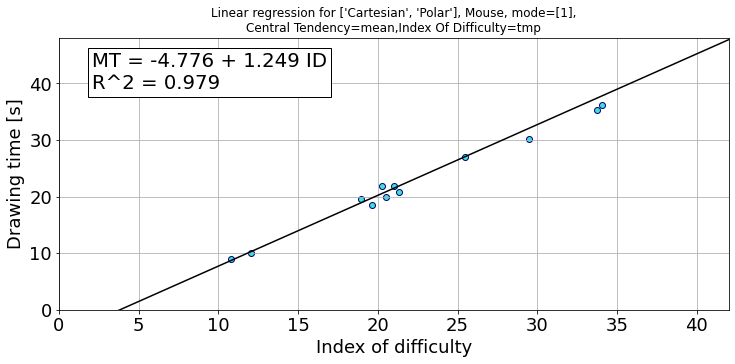



SKLEARN
Linear regression for ['Cartesian', 'Polar'], Graphic tablet, mode=[0],
Central Tendency=mean,Index Of Difficulty=tmp
3.1913558967552955
MT = 1.190x + -3.235
R^2 = 0.991
MSE = 0.786
RMSPE = 3.191%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5922712087631226
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.5922712087631226
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative 

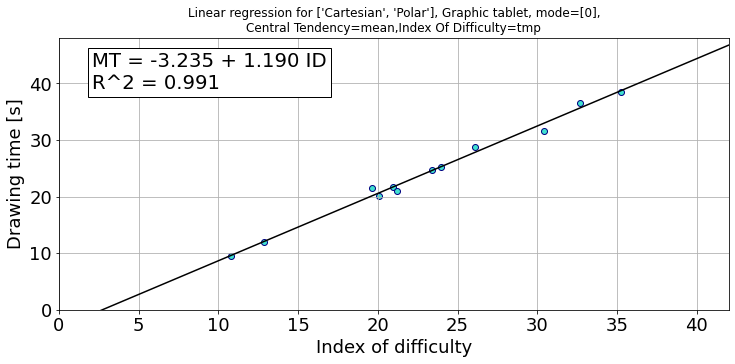

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.2351531982421875
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.2351531982421875
Residuals are normally distributed

Assumption satisfied
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.4867226314980792
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals 

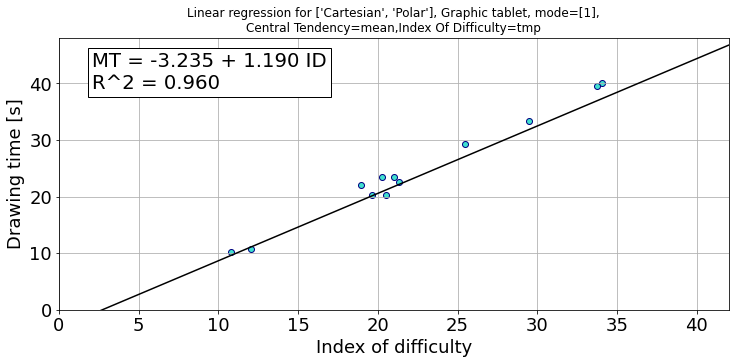

In [9]:
for projections in [["Cartesian"], ["Polar"], args.PROJECTIONS]:
    for device in args.DEVICES:
        AN.trainRegressionModelThenValidate(projections, device)
        
        #reg2 = getRegressionModel(projections, [0, 1], device)
        # test the residuals as shown here: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

# Participant data

Particpant age mean      :  23.542
Particpant age median    :  24.000
Particpant age stdev     :   1.154


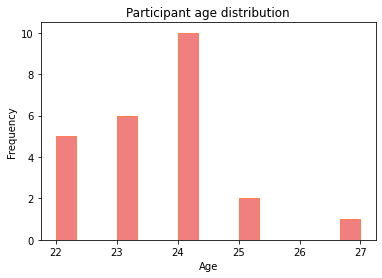

Right-handed    21
Left-handed      3
Name: Participant handedness, dtype: int64


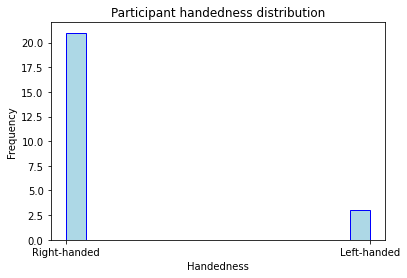

** Expert mouse users (0=Not expert, 1=Is Expert):
1    24
Name: Expert Mouse User, dtype: int64
** Expert GT users (0=Not expert, 1=Is Expert):
0    23
1     1
Name: Expert Graphic Tablet User, dtype: int64


In [19]:
PA.get_age_histogram(); plt.show()
PA.get_handedness_histogram(); plt.show()
PA.get_device_experience()

In [ ]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
handednessFreq = {
    "Left-handed": 0,
    "Right-handed": 0,
    "Ambidextrous": 0
}
hasExpWTablet = 0
hasExpWMouse = 0
for participant in participants:
    row = df.query(f'`Participant name` == "{participant}"').iloc[0]
    age = row['Participant age']
    handednessFreq[row['Participant handedness']] += 1
    hasExpWTablet += row['Expert Graphic Tablet User']
    hasExpWMouse += row['Expert Mouse User']
    # print(participant, age)
    ages.append(age)

plt.figure(figsize=(10,6))
plt.hist(ages, color="lightcoral", bins=15, edgecolor="coral")
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
if useCroatian is True:
    plt.ylabel("Broj")
    plt.xlabel("Godine")
    plt.title("")
    # plt.title("Starosna distribucija ispitanika")
saveFigure(participantDataFolderPath + "participant_age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))
print("Standard deviation:", round(np.std(ages), 3))

print("\n ::::")

for handedness in handednessFreq:
    freq = handednessFreq[handedness]
    print("Number of " + handedness + " participants:", freq)
    print("Percentage of " + handedness + " participants", round(freq * 1.0 / len(participants), 3)*100, '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3)*100, '%'
)

print("Number of expert mouse participants:", hasExpWMouse)
print("Percentage of expert graphic tablet participants",
      round(hasExpWMouse * 1.0 / len(participants), 3)*100, '%'
)

print("\n ::::")
print("Average drawing times")


# separator is semicolon because the 'projections' column has commas in it
separator = ';'

# Average drawing time per user
sortedParticipants = sorted(participants)
figure, axes = plt.subplots(len(DEVICES), len([["Cartesian"], ["Polar"], PROJECTIONS]))
figure.set_size_inches(15, 7)

for k, device in enumerate(DEVICES):
    for j, projections in enumerate([["Cartesian"], ["Polar"], PROJECTIONS]):
        pltData = []
        print("Participant","Device", "Projections","Drawing Time Mean", "Drawing time stdev", sep=separator)
        for i in range(len(sortedParticipants)):
            participant = sortedParticipants[i]
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes, _ = getAvgsByFilter(projections, [funcId], [device], [experimentMode], data=drawingTimes)
                    dts.append(drawingTimes)
            # print(participant, device, projections, round(np.mean(dts), 4), round(np.std(dts), 4), sep=separator)
            pltData.append(np.mean(dts))
        # print()
        ax = axes[k][j]
        ax.hist(pltData, color='skyblue', bins=15, edgecolor="navy")

        pValueNormDist = isDataNormallyDistributed(np.array(pltData))
        
        title = "Average drawing time for \n Device %s, Projection(s) %s" %(device, projections)
        ax.set_ylabel("Count")
        ax.set_xlabel("Average drawing time [seconds]\nNorm dist p_value=%.5f" % (pValueNormDist))
        
        if useCroatian is True:
            title = "Prosječno vrijeme crtanja za: \n Uređaj: %s, Projekcija(e): %s" %(translate(device), 
                                                                                   translate(projections))
            ax.set_ylabel("Broj")
            ax.set_xlabel("Vrijeme [s]") #"\nNorm dist p_value=%.5f" % (pValueNormDist))
        ax.set_title(title)
        
        # this lim is hard-coded. if I ever have time, I should make this soft-coded :)
        ax.set_ylim([0, 7])
        ax.set_xlim([10, MAX_AVG_DRAW_TIME])
        print("\n\n")

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Average_drawing_times")
plt.show()
            


## Error approximation

In [ ]:
sortedParticipants = sorted(participants)
"""
# PLEASE NOTE, this is not correct. The error rate which was calculated in the "Throughput calculation"
# part is the one that /is/ correct.

print("Participant index", "Mouse error mean", "Mouse error stdev", "Graphic tablet error mean", "Graphic tablet error stdev", sep=separator)
avgs = { "Mouse":[], "Graphic tablet":[]}
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    print(participant, end='')
    for device in DEVICES:
        # epm = error per move
        epms = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                                
                # NOTE: This formula is not really correct. Check "Throughput calculation" for the right one.
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                
                epms.append(errorVal)
                f.close()
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        print('', round(np.mean(epms), 6), round(np.std(epms), 6), sep=separator, end='')
        avgs[device].append(np.mean(epms))
    print()
"""

In [ ]:
"""
maxAvg = np.max([np.max(avgs["Mouse"]), np.max(avgs["Graphic tablet"])])
minAvg = np.min([np.min(avgs["Mouse"]), np.min(avgs["Graphic tablet"])])
xlim = [minAvg - 0.005, maxAvg + 0.005]
    
figure, (ax1, ax2) = plt.subplots(2)
figure.set_size_inches(5, 8)
ax1.hist(avgs["Mouse"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Mouse"]))

title = "Average error rate distribution, Mouse"
ax1.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax1.set_ylabel("Participant count")

if useCroatian is True:
    title = "Distrubucija prosječne pogreške, Miš"
    ax1.set_xlabel("Iznos pogreške")
    ax1.set_ylabel("Broj ispitanika")
    
ax1.set_title(title)
ax1.set_ylim([0, 6])
ax1.set_xlim(xlim)

ax2.hist(avgs["Graphic tablet"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Graphic tablet"]))

title = "Average error rate distribution, Graphic tablet"

ax2.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax2.set_ylabel("Participant count")
if useCroatian is True:
    title = "Distribucija prosječne pogreške, Grafički tablet"
    ax2.set_xlabel("Iznos pogreške")
    ax2.set_ylabel("Broj ispitanika")

ax2.set_title(title)
ax2.set_ylim([0, 6])
ax2.set_xlim(xlim)

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Error_rates_dist")
plt.show()
"""

## Throughput calculation

In [ ]:
sortedParticipants = sorted(participants)

fp = curve_functions.FunctionProvider()

x = sp.Symbol("x")

# array of ALL throughputs for mouse, i.e. TPs from ALL participants
allTPsForMouse = []
allTPsForGraphicTablet = []

## NOTE::: look in calculate_integrals.y
# this throughput calculation is not exactly correct :)
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    # print(participant, end='')
    # this will have two values; one for each device
    TPsForThisParticipant = {}
    
    for device in DEVICES:
        # the average throughput for this participant and this device
        # each user produces two throughputs: one for each device
        TPsForThisDevice = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            
            # each curve was passed through twice on each device,
            # so for example, curve with ID=1 and proj=2, was passed through twice on Mouse,
            # and then twice on graphic tablet.
            # We must find the average st dev for those two passes
            
            # 4= [0,1,2,3], testmode + projection combo
            errorStDevForFunc = np.zeros((len(FUNC_IDS), 4))
            
            for file in sorted(files):

                funcId = int(file[3])
                projtmp = file[10]
                # we are searching for an entry in the logs which can tell us
                # the average MT for user
                # and the st dev of error rate for user.
                # from the stdev of error rate, we will caluclate effective width of target (W_e)
                # and from that we'll get effective index of difficulty - ID_e
                # when we divide ID_e by the MT of the user, we get the user's throughput for a single curve
                # and then we find the mean of all throughputs for this user, which we
                # then use for t-test to compare the two pointing devices
                
                f = open(filename + "/" + file)
                    
                # find the stdev of the error by dividing the sum of errors with the square root of
                # the number of points (this is the stdev formula)
                pointsDrawn = [pointDrawn.replace('\n', '') for pointDrawn in f.readlines()]
                f.close()

                test = int(projtmp)        
                difficulty = int(int(funcId) / 2)
                task = int(funcId) % 2
                real_func = fp.provide_function(difficulty, task, test)
                real_func = sp.lambdify(x, real_func)

                # ALL of the error the user had made on this specific curve
                allErrorVals = []

                for pointDrawn in pointsDrawn:
                    x_coord = float(pointDrawn.split()[0])
                    y_coord = float(pointDrawn.split()[1])
                    real_y = real_func(x_coord)

                    y_diff = abs(y_coord - real_y)

                    if(projtmp in ["2", "3"]):
                        # polar projection, erroval should be multiplied with the polar unit length
                        # so that we get effective width in inches
                        y_diff *= display_properties.POLAR_UNIT_LENGTH_IN_INCH
                    else:
                        y_diff *= display_properties.CARTESIAN_UNIT_LENGTH_IN_INCH

                    allErrorVals.append(y_diff)
                # print(np.mean(allErrorVals), np.std(allErrorVals))
                errorVal = np.std(allErrorVals)
                # print(funcId, int(projtmp))
                errorStDevForFunc[funcId][int(projtmp)] += errorVal
            # print(errorStDevForFunc)
                
            for projtmp in [0, 1, 2, 3]:
                for funcId in FUNC_IDS: 
                    
                    projection = "Cartesian"
                    if(projtmp in [2, 3]):
                        projection="Polar"
                        
                    # filter out by projection, Cartesian or Polar
                    participantMovement = df[df['Function projection'] == projection]
                    # filter out by function ID
                    participantMovement = participantMovement[participantMovement['Function ID'] == funcId]
                    # filter out by test (experiment mode)
                    participantMovement = participantMovement[participantMovement['Test mode'] == experimentMode]
                    participantMovement = participantMovement[participantMovement['Participant name'] == participant]
                    # filter out by device
                    participantMovement = participantMovement[participantMovement['Device'] == device]
                    
                    # this is from the effective target width (Fitts law), a true-tried-tested formula
                    # we have to divide it by 2 because there are two passes through this curve
                    # and we're looking for the mean of the standard deviation
                    W_e = 4.133 * errorStDevForFunc[funcId][projtmp] / 2
                    if(W_e <= 0):
                        continue

                    # calculate effective ID_e for this W_e
                    kappa = getIodForFunc(projection, experimentMode, funcId, 'kappa')

                    length = getIodForFunc(projection, experimentMode, funcId, 'length')

                    # Id_e = np.log2(length / W_e + kappa + 1)
                    Id_e = length / W_e + kappa

                    # movement time
                    MT = np.mean(participantMovement["Drawing time"].values)

                    # throughput for this curve and this specific user
                    TP = Id_e / MT
                    TPsForThisDevice.append(TP)
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        # this is where the loop for each device ends --> we have to calculate
        # the avg throughput for this participant and this device

        TPsForThisParticipant[device] = np.mean(TPsForThisDevice)
    print(participant, TPsForThisParticipant["Mouse"], TPsForThisParticipant["Graphic tablet"], sep=separator)
    # 3/0
    allTPsForMouse.append(TPsForThisParticipant["Mouse"])
    allTPsForGraphicTablet.append(TPsForThisParticipant["Graphic tablet"])


In [ ]:
# now we should test whether the TPs are normally distributed

for i, tps in enumerate([allTPsForMouse, allTPsForGraphicTablet]):
    pValueNormDist = isDataNormallyDistributed(np.array(tps))
    device = DEVICES[i]
    
    plt.figure(figsize=(8,5))
    plt.hist(tps, color="lightgreen", edgecolor="green")
    title = "Average throughput distribution, " + device
    xlabel = "Average throughput, [bit/s]\nNorm dist p_value=%.5f" % (pValueNormDist)
    ylabel = "Participant count"

    if useCroatian is True:
        title = "Histogram prosječne propusnosti, " + translate(device)
        xlabel = "Propusnost [bit/s]"
        ylabel = "Broj ispitanika"

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # these limits are hard-coded, and they're here to make the histograms have the same x 
    # and y ranges on both plots
    plt.xlim([3, 9.5])
    plt.ylim([0, 5.5])
    
    saveFigure(participantDataFolderPath + "Throughput_dist" +  device)
    plt.show()
